In [0]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
import math
from torchsummary import summary

In [0]:
class ResBlock(nn.Module):
  def __init__(self):
    super(ResBlock, self).__init__()

    self.conv1 = nn.Conv2d(1,64,3,padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(64,64,3,padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(2)
  
  def forward(self,x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out += identity
    out = self.relu1(out)
    out = self.maxpool1(out)

    identity = out

    out = self.conv2(out)
    out = self.bn2(out)
    out += identity
    out = self.relu2(out)
    out = self.maxpool2(out)

    return out

In [0]:
class ChoiceNet(nn.Module):
  def __init__(self, y_dim, num_mixture, feature_dim, logSigmaZval, tau_inv, pi1_bias):
    super(ChoiceNet,self).__init__()
    #self.backbone = backbone
    self.y_dim = y_dim
    self.num_mixture = num_mixture
    self.feature_dim = feature_dim
    self.logSigmaZval = logSigmaZval
    self.tau_inv = tau_inv
    self.pi1_bias = pi1_bias
    self.rho_ref = 0.95
    #self.USE_GAT = USE_GAT
    
    self.ResBlock = ResBlock()

    # self.back_bone = nn.Sequential(
    #     nn.Conv2d(1,64,3,padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2),
    #     nn.Conv2d(64,64,3,padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2)   
    # )
    
    self.fc_feature_dim = nn.Linear(7*7*64, self.feature_dim)
    self.fc_num_mixture = nn.Linear(self.feature_dim, num_mixture)

    self.fc_var_raw = nn.Linear(self.feature_dim, self.y_dim)

    self.fc_pi_logits = nn.Linear(self.feature_dim, self.num_mixture)

  def forward(self, x):
    #x = self.back_bone(x)
    x = self.ResBlock(x)
    x = x.view(x.size(0),-1) # flatten
    #print('x : ',x)
    self.feature = self.fc_feature_dim(x) # feature, h
    #print(self.feature.size())
    
    with torch.enable_grad():
      rho_raw = self.fc_num_mixture(self.feature)
      rho_temp = F.sigmoid(rho_raw)
      rho = torch.cat([rho_temp[:, 0:1]*0.0 + self.rho_ref, rho_temp[:, 1:]], axis=1) # rho(h)=rho1~rhoK, rho_ref=1

      #print('rho_raw : ',rho_raw)
      #print('rho_temp : ',rho_temp)
      Q = self.feature_dim
      num_data = x.size()[0]

    #make_sample
      muW_tile, muZ_tile, sigmaW_tile, sigmaZ_tile = self.make_sample(Q, num_data) 
      # print('muW_tile : ',muW_tile, 
      #       '\nmuZ_tile : ',muZ_tile, 
      #       '\nsigmaW_tile : ',sigmaW_tile, 
      #       '\nsigmaZ_tile : ',sigmaZ_tile)
    
    # cholesky #[K*N*Q*D] #W_bar
    #branch_2
      samplerList = self.cholesky(self.num_mixture, Q, rho, num_data, muW_tile, sigmaW_tile, muZ_tile, sigmaZ_tile)
      wSample = samplerList.permute(1,3,0,2) #[N*D*K*Q]

    #K mean mixtures
      wTemp = wSample.contiguous().view(num_data, self.num_mixture*self.y_dim, Q)
      featRsh = self.feature.view(num_data, Q, 1)
      _mu = torch.matmul(wTemp, featRsh) #[N*DK*1]
      mu = _mu.view(num_data, self.y_dim, self.num_mixture)

    ### Add bias to mu (after)

    #K var mixtures #(6) 
    #branch_3
      logvar_raw = self.fc_var_raw(self.feature) #[N*D]
      var_raw = torch.exp(logvar_raw)
      #print('logvar_raw:',logvar_raw)
      var_tile = var_raw.unsqueeze(-1).repeat(1, 1, self.num_mixture) #N*D*K
      rho_tile = rho.unsqueeze(1).repeat(1, self.y_dim, 1)#N,D,K
      tau_inv = self.tau_inv
      var = (1.0 - torch.pow(rho_tile,2))*var_tile + tau_inv

    # Weight allocation probability pi [N*K] # pi_k = softmax()_k
    #branch_1
      pi_logits = self.fc_pi_logits(self.feature) #[N*K]
      pi_temp = F.softmax(pi_logits, dim=1)
      pi_temp = torch.cat((pi_temp[:, 0:1] + self.pi1_bias, pi_temp[:, 1:]), axis=1)
      pi = F.softmax(pi_temp, dim=1)

    return rho, mu, var, pi
    

  def make_sample(self, Q, num_data):
    N = num_data

    muW = torch.nn.init.normal_(torch.empty(Q, self.y_dim), mean = 0.0, std = 0.1)
    #muW = torch.normal(std=0.1,size=(Q, self.y_dim)) # Q*D
    logSigmaW = torch.nn.init.constant_(torch.empty(Q, self.y_dim), -3.0)
    #print('logSigmaW : ',logSigmaW)
    muZ = torch.zeros(Q, self.y_dim) # Q*D
    logSigmaZ = torch.nn.init.constant_(torch.empty(Q, self.y_dim), self.logSigmaZval)
    #print('logSigmaZ : ',logSigmaZ)
    muW_tile = muW.unsqueeze(0).repeat(N,1,1) # N*Q*D
    sigmaW_tile = torch.exp(logSigmaW.unsqueeze(0).repeat(N,1,1)) #N*Q*D
    
    muZ_tile = muZ.unsqueeze(0).repeat(N,1,1)
    sigmaZ_tile = torch.exp(logSigmaZ.unsqueeze(0).repeat(N,1,1))

    return muW_tile, muZ_tile, sigmaW_tile, sigmaZ_tile

  def cholesky(self, num_mixture, Q, rho, num_data, muW_tile, sigmaW_tile, muZ_tile, sigmaZ_tile):
    samplerList = []
    for mix_idx in range(self.num_mixture):
      rho_j = rho[:, mix_idx : mix_idx+1] # N*1
      rho_tile = rho_j.unsqueeze(-1).repeat(1, Q, self.y_dim) # N*Q*D
      
      epsW = torch.randn(num_data, Q, self.y_dim, dtype=torch.float) #mean=0, std=1
      W = muW_tile + torch.sqrt(sigmaW_tile)*epsW
      
      epsZ = torch.randn(num_data, Q, self.y_dim, dtype=torch.float)
      Z = muZ_tile + torch.sqrt(sigmaZ_tile)*epsZ

      #Cholesky
      Y = rho_tile*muW_tile + (1.0 - torch.pow(rho_tile,2))\
                               *(rho_tile*torch.sqrt(sigmaZ_tile)/torch.sqrt(sigmaW_tile)\
                                 *(W - muW_tile) + Z*torch.sqrt(1 - torch.pow(rho_tile,2)))
                               
      #print('Y: ' ,Y)
      samplerList.append(Y)
    return torch.stack(samplerList)


In [0]:
def ChoiceNet_Mnist():
  return ChoiceNet(y_dim, num_mixture, feature_dim, logSigmaZval, tau_inv, pi1_bias)
  # return ChoiceNet(make_layers(in_channels, h_dim, filter_size, max_pools, activation, batch_norm ),
  #                  y_dim, num_mixture, feature_dim, logSigmaZval, tau_inv, pi1_bias)

In [0]:
def train(model,epoch):
  model.train()
  for batch_idx, (data,target) in enumerate(train_loader):
    if args['cuda']:
      data, target = data.cuda(), target.cuda()
    
    temp = torch.LongTensor(1000,1).random_() % 10
    y_onehot = torch.FloatTensor(1000,10)

    y_onehot.zero_()
    y_onehot.scatter_(1, temp, 1)
    
    #data, target = Variable(data), Variable(y_onehot)
    data, target = Variable(data), Variable(y_onehot)
    #GRAD_CLIP = True, USE_SGD = False

    optimizer.zero_grad()

    rho, mu, var, pi = model(data)
    #print('rho : ',rho,'\nmu : ', mu,'\nvar :' ,var,'\npi : ', pi)
    loss, acc = MDNloss(len(data), rho, mu, var, pi, target, y_dim=10, num_mixture=10, logsumexp_coef= 1e-2, kl_reg_coef= 1e-4).forward()
    
    loss.backward()

    print(acc)

    optimizer.step()

    if batch_idx%args['log_interval'] == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. *batch_idx/len(train_loader), loss.data
      ))


In [0]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  for data,target in test_loader:
    if args['cuda']:
      data, target = data.cuda(), target.cuda()
    
    temp = torch.LongTensor(1000,1).random_() % 10
    y_onehot = torch.FloatTensor(1000,10)

    y_onehot.zero_()
    y_onehot.scatter_(1, temp, 1)
    
    data, target = Variable(data), Variable(y_onehot)

    rho, mu, var, pi = model(data)
    

    loss , acc = MDNloss(len(data), rho, mu, var, pi, target, y_dim=10, num_mixture=10, logsumexp_coef= 1e-2, kl_reg_coef= 1e-4).forward()
    test_loss += loss
    correct += acc#accuracy(pi,mu, len(data) ,target, y_dim=10)
  
  loss /= len(test_loader.dataset)
  print('\nTest set : Average loss : {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)))



In [0]:
def train_overfit(epoch):
  model.train()
  for batch_idx, (data,target) in enumerate(train_loader):
    if args['cuda']:
        data, target = data.cuda(), target.cuda()
      
    temp = torch.LongTensor(1000,1).random_() % 10
    y_onehot = torch.FloatTensor(1000,10)

    y_onehot.zero_()
    y_onehot.scatter_(1, temp, 1)
      
      #data, target = Variable(data), Variable(y_onehot)
    data, target = Variable(data[0:2]), Variable(y_onehot[0:2])
    #print(data, target)
    for i in range(100):
      
      #GRAD_CLIP = True, USE_SGD = False

      optimizer.zero_grad()

      rho, mu, var, pi = model(data)
      #print('rho : ',rho,'\nmu : ', mu,'\nvar :' ,var,'\npi : ', pi)
      loss, acc = MDNloss(len(data), rho, mu, var, pi, target, y_dim=10, num_mixture=5, logsumexp_coef= 1e-2, kl_reg_coef= 1e-4).forward()
      
      loss.backward()

      print(acc)

      optimizer.step()

      if batch_idx%args['log_interval'] == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. *batch_idx/len(train_loader), loss.data
        ))
    break


In [0]:
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  for data,target in test_loader:
    if args['cuda']:
      data, target = data.cuda(), target.cuda()
    
    temp = torch.LongTensor(1000,1).random_() % 10
    y_onehot = torch.FloatTensor(1000,10)

    y_onehot.zero_()
    y_onehot.scatter_(1, temp, 1)
    
    data, target = Variable(data), Variable(y_onehot)

    rho, mu, var, pi = model(data)
    

    loss , acc = MDNloss(len(data), rho, mu, var, pi, target, y_dim=10, num_mixture=10, logsumexp_coef= 1e-2, kl_reg_coef= 1e-4).forward()
    test_loss += loss
    correct += acc#accuracy(pi,mu, len(data) ,target, y_dim=10)
  
  loss /= len(test_loader.dataset)
  print('\nTest set : Average loss : {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)))



In [0]:
class MDNloss(nn.Module):
  def __init__(self, num_data, rho, mu, var, pi, target, y_dim, num_mixture, logsumexp_coef, kl_reg_coef):
    super(MDNloss, self).__init__()
    self.num_data = num_data
    self.rho = rho #N*K
    self.mu = mu #N*D*K
    self.var = var #N*D*K
    self.pi = pi #N*K
    self.target = target
    self.y_dim = y_dim
    self.num_mixture = num_mixture
    self.logsumexp_coef = logsumexp_coef
    self.kl_reg_coef = kl_reg_coef

    #print(self.var)

    self.yhat = self.mu + torch.sqrt(self.var)*torch.randn(self.num_data, self.y_dim, self.num_mixture)

  def forward(self):
    #with torch.no_grad():
    target_tile = self.target.unsqueeze(-1).repeat(1, 1, self.num_mixture)# N*D*K
    pi_tile = self.pi.unsqueeze(1).repeat(1, self.y_dim, 1) # N*D*K

    yhat_normalized = F.softmax(self.yhat, dim=1)
    _loss_fit = torch.sum(-pi_tile*yhat_normalized*target_tile, axis=[1,2])
    loss_fit = torch.mean(_loss_fit)

    _loss_reg = self.pi*torch.logsumexp(self.yhat,axis=[1])
    __loss_reg = torch.sum(_loss_reg,axis=[1])
    loss_reg = self.logsumexp_coef*torch.mean(__loss_reg)

    _eps = 1e-8
    _kl_reg = self.kl_reg_coef*torch.sum(-self.rho*(torch.log(self.pi+_eps) - torch.log(self.rho+_eps)), axis=1)
    kl_reg = torch.mean(_kl_reg)
    # prob = self.pi*self.g_p(self.var,self.mu,self.target)
    # nll = -torch.log(torch.sum(prob,dim=1))

    acc = self.acc()

    print(loss_fit.item() ,'+', loss_reg.item() ,'+', kl_reg.item(),'=',torch.mean(loss_fit + loss_reg + kl_reg))
 
    #print('yhat:',torch.argmax(yhat_normalized,dim=1))
    #print('pi : ', self.pi)
    #print('target:',torch.argmax(self.target,dim=1))
    return torch.mean(loss_fit + loss_reg + kl_reg), acc

  def acc(self):
    #print(self.pi)
    y = self.yhat[:,:,0] #N*D
    #print('y',torch.argmax(y,dim=1))
    #print('target',torch.argmax(self.target,dim=1))
    acc = (torch.argmax(y,dim=1) == torch.argmax(self.target,dim=1)).sum().item()/y.size()[0]

    return acc
    #self.target #N*D

  

In [10]:
args = {}
kwargs = {}
args['batch_size'] = 1000
args['test_batch_size'] = 1000
args['epochs'] = 50
args['lr'] = 1e-5
args['momentum'] = 0.5

args['seed'] = 1
args['log_interval'] = 10
args['cuda'] = False

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))
                   ])),
                   batch_size = args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))
                   ])),
                   batch_size = args['test_batch_size'], shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [11]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

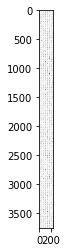

In [12]:
writer = SummaryWriter('runs/ChoiceNet_mnist_experiment_1')

dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)
#matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('ChoiceNet_mnist_images', img_grid)

In [17]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.normal(m.weight)
    #torch.nn.init.xavier_normal(m.weight)
  if type(m) == nn.Conv2d:
    torch.nn.init.normal(m.weight)
    #torch.nn.init.xavier_normal(m.weight)

model = ChoiceNet(y_dim=10, num_mixture=10, feature_dim=256, logSigmaZval=-2, tau_inv=1e-4, pi1_bias=0.0)
#model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=1e-5)

summary(model,(1,28,28))

for name, param in model.named_parameters():
  if param.requires_grad:
    print (name, param.data.size())
for epoch in range(1, args['epochs']+1):
  train(model,epoch)
  test(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
          ResBlock-9             [-1, 64, 7, 7]               0
           Linear-10                  [-1, 256]         803,072
           Linear-11                   [-1, 10]           2,570
           Linear-12                   [-1, 10]           2,570
           Linear-13                   [-1, 10]           2,570
Total params: 848,606
Trainable params:

KeyboardInterrupt: ignored